# Train mask over IOI edges and analyze mask vs known circuit

In [1]:
from models import load_gpt2_weights, load_demo_gpt2, tokenizer
from data import retrieve_toxic_data, retrieve_owt_data, retrieve_toxic_data_low_loss, retrieve_toxic_filtered_data, FILTER_DEMO_LEN, CONTEXT_LENGTH
from inference import infer_batch_with_owt, infer_batch, prepare_fixed_demo, criterion
from torch.optim import AdamW
import torch
import pickle
import datasets
from tqdm import tqdm_notebook as tqdm
from itertools import cycle
from eval import evaluate_model
from data import batch_text_to_tokens
import plotly.express as px

Using device: cuda:0


In [46]:
toxic_batch_size = 1 # so that we can just access the last sequence position without worrying about padding
owt_batch_size = 5
context_length = CONTEXT_LENGTH

toxic_data_loader = retrieve_toxic_data(toxic_batch_size, context_length, tokenizer, tokenize=False, num_points=None)
# toxic_data_loader = retrieve_toxic_filtered_data(toxic_batch_size)
owt_data_loader = retrieve_owt_data(owt_batch_size)

with open("data/gpt2_means.pkl", "rb") as f:
    means = pickle.load(f)[0][0]

model = load_demo_gpt2(means=False)
epochs_left = 200
log_every = 20
lr = .05 # free
weight_decay = 0
clamp_every = 20 # 5 # free
threshold = 0.5
epochs_trained = 0
regularization_strength = 2 # free

mask_params = []
param_names = []
for name, p in model.named_parameters():
    if p.requires_grad:
        param_names.append(name)
        mask_params.append(p)
optimizer = AdamW(mask_params, lr=lr, weight_decay=weight_decay)

losses = []
num_ablated_edges = []
alpha = 0.2 # free
batch_size = toxic_batch_size + owt_batch_size
demos = prepare_fixed_demo(tokenizer, batch_size, demo="")
owt_iter = cycle(owt_data_loader)
edge_threshold = 100
max_steps_per_epoch = 100


## Train params of mask

In [47]:
old_mask_params = {}
def duplicate_mask_params(mask_params):
    new_mask_params = []
    for p in mask_params:
        new_mask_params.append(p.data.cpu())
    return new_mask_params

prev_params = None
while epochs_left >= 0:
    for e in tqdm(range(epochs_left)):
        for c, batch in enumerate(toxic_data_loader):
            if c > max_steps_per_epoch:
                break

            # print(batch["text"])
            total_preserving = 0
            ablated_edges = 0
            penalty = 0
            for p in mask_params:
                total_preserving += p.sum()
                ablated_edges += p[p.data < 0.5].shape[0]
                penalty += max(0, p.sum() * (epochs_trained-20) / 10000) # why 2000? free

            # demos = batch[:, :FILTER_DEMO_LEN]
            # completions = batch[:, FILTER_DEMO_LEN:]

            # tox_loss = infer_batch(model, criterion, completions, toxic_batch_size, demos)
            # owt_loss = infer_batch(model, criterion, next(owt_iter)['tokens'], owt_batch_size, fixed_demos)
            tox_loss, owt_loss = infer_batch_with_owt(model, criterion, batch, next(owt_iter), batch_size, demos, access_toxic_pos=-1)
            # print(f"{tox_loss=}, {owt_loss=}")
            loss = -1 * (regularization_strength * penalty + alpha * tox_loss) + owt_loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            num_ablated_edges.append(ablated_edges)
            for p in mask_params:
                p.data.clamp_(0,1)
        print(f"{loss.item()=}, {ablated_edges=}")
        epochs_trained += 1
        if epochs_trained % clamp_every == 0:
            ablated_edges = 0
            for p in mask_params:
                p.data[p.data < threshold] = 0
                p.data[p.data >= threshold] = 1
                ablated_edges += p[p.data < 0.5].shape[0]
        if epochs_trained % log_every == 0:
            print("Epochs trained: ", epochs_trained)
            print(f"Loss: {loss.item():.4f}")
            print(f"Total preserved: {total_preserving:.4f}")
            print("Edges ablated: ", ablated_edges)
            print("Toxic loss: ", tox_loss.item())
            print("OWT loss: ", owt_loss.item())
            print("Penalty: ", penalty)
            # if input('evaluate? (y)') == 'y':
            #     evaluate_model(model, toxic_batches=1, owt_batches=1)
            print("\n")
            old_mask_params[epochs_trained] = duplicate_mask_params(mask_params)
                
        if epochs_trained > 50 and ablated_edges < edge_threshold:
            break
        prev_params = mask_params
    epochs_left = int(input('continue training for this number of epochs: '))
    log_every = int(input('set log frequency'))
    edge_threshold = int(input('set edge threshold'))

/tmp/ipykernel_30385/2404806392.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm(range(epochs_left)):


  0%|          | 0/200 [00:00<?, ?it/s]

loss.item()=-16.89109230041504, ablated_edges=3149
loss.item()=-19.500574111938477, ablated_edges=3942
loss.item()=-18.821674346923828, ablated_edges=4561
loss.item()=-20.007720947265625, ablated_edges=4884
loss.item()=-20.551010131835938, ablated_edges=5094
loss.item()=-21.655017852783203, ablated_edges=5206
loss.item()=-19.20555877685547, ablated_edges=5310
loss.item()=-19.8255672454834, ablated_edges=5385
loss.item()=-21.020761489868164, ablated_edges=5454
loss.item()=-18.9996280670166, ablated_edges=5523
loss.item()=-18.73343849182129, ablated_edges=5513
loss.item()=-19.11676025390625, ablated_edges=5610
loss.item()=-18.595947265625, ablated_edges=5599
loss.item()=-19.765188217163086, ablated_edges=5590
loss.item()=-20.780019760131836, ablated_edges=5616
loss.item()=-20.084991455078125, ablated_edges=5630
loss.item()=-19.438697814941406, ablated_edges=5653
loss.item()=-19.164213180541992, ablated_edges=5625
loss.item()=-20.70319175720215, ablated_edges=5638
loss.item()=-18.40142822

ValueError: invalid literal for int() with base 10: ''

In [49]:
with open(f"models/params_dict_lambda={regularization_strength}.pkl", "wb") as f:
    pickle.dump(old_mask_params, f)

In [21]:
total_preserving = 0
for p in mask_params:
    p.data[p.data < threshold] = 0
    p.data[p.data >= threshold] = 1
    total_preserving += p.data.sum()
print(total_preserving)

tensor(11373., device='cuda:0')


In [11]:
def duplicate_mask_params(mask_params):
    new_mask_params = []
    for p in mask_params:
        new_mask_params.append(p.data.cpu())
    return new_mask_params
mask_params_copy = duplicate_mask_params(mask_params)

In [5]:
for idx in range(len(mask_params)):
    print(f"{param_names[idx]}: {mask_params[idx].shape}")

output_mask: torch.Size([157])
blocks.0.edge_mask_attentions: torch.Size([1, 12])
blocks.0.edge_mask_mlp: torch.Size([13])
blocks.1.edge_mask_attentions: torch.Size([14, 12])
blocks.1.edge_mask_mlp: torch.Size([26])
blocks.2.edge_mask_attentions: torch.Size([27, 12])
blocks.2.edge_mask_mlp: torch.Size([39])
blocks.3.edge_mask_attentions: torch.Size([40, 12])
blocks.3.edge_mask_mlp: torch.Size([52])
blocks.4.edge_mask_attentions: torch.Size([53, 12])
blocks.4.edge_mask_mlp: torch.Size([65])
blocks.5.edge_mask_attentions: torch.Size([66, 12])
blocks.5.edge_mask_mlp: torch.Size([78])
blocks.6.edge_mask_attentions: torch.Size([79, 12])
blocks.6.edge_mask_mlp: torch.Size([91])
blocks.7.edge_mask_attentions: torch.Size([92, 12])
blocks.7.edge_mask_mlp: torch.Size([104])
blocks.8.edge_mask_attentions: torch.Size([105, 12])
blocks.8.edge_mask_mlp: torch.Size([117])
blocks.9.edge_mask_attentions: torch.Size([118, 12])
blocks.9.edge_mask_mlp: torch.Size([130])
blocks.10.edge_mask_attentions: tor

In [18]:
old_mask_params.keys()

dict_keys([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])

## Test model before and after circuit breaking

In [ ]:
import pickle
with open("data/ioi_sentences_test.pkl", "rb") as f:
    ioi_sentences_test = pickle.load(f)
    # ioi_sentences_test = [t[2] for t in ioi_sentences_test]

with open("data/eval_uniform.pkl", "rb") as f:
    uniform_samples = pickle.load(f)
    uniform_sentences = [t[2] for t in uniform_samples]

original_model = load_demo_gpt2(means=False)

with open("models/masked_gpt2_mean_ablation_v6.pkl", "rb") as f:
    model.state_dict = pickle.load(f)

In [ ]:
# Run inference on an ioi_sentence
ioi_sentence = ioi_sentences_test[0]
print(ioi_sentence)
# ioi_tokens = tokenizer(ioi_sentence, return_tensors='pt').input_ids.to('cuda')

original_model.eval()
original_model.to('cuda')
def get_last_token(model, prompt, topk=5):
    # generate last token
    tokens = tokenizer(prompt, return_tensors='pt').input_ids[:, :-1]

    # generate one token, decode original_model(ioi_tokens[:, :-1])
    model_outputs = model(tokens)[0]
    model_outputs = model_outputs.squeeze(0)[-1]
    probs = torch.nn.functional.softmax(model_outputs, dim=-1)

    topk_outputs = torch.topk(model_outputs, topk)
    topk_tokens = topk_outputs.indices
    topk_probs = probs[topk_outputs.indices]
    
    # decode tokens
    for i in range(topk):
        print(f"{tokenizer.decode(topk_tokens[i].unsqueeze(0))}, probability of {topk_probs[i]}")
    topk_tokens_decoded = tokenizer.batch_decode(topk_tokens)
    return topk_tokens_decoded, topk_probs

print("Before ablation")
_ = get_last_token(original_model, ioi_sentence)
print()
print()
print("After ablation")
_ = get_last_token(model, ioi_sentence)

Then, John and Ryan had a lot of fun at the office. John gave a snack to Ryan
Before ablation
 Ryan, probability of 0.3558429777622223
 his, probability of 0.11594294011592865
 the, probability of 0.08989984542131424
 John, probability of 0.031978804618120193
 a, probability of 0.023939691483974457


After ablation
 use, probability of 0.999350368976593
 share, probability of 8.960117702372372e-05
 take, probability of 8.413783507421613e-05
 try, probability of 7.346251368289813e-05
 apply, probability of 4.8839792725630105e-05


In [ ]:
# Try on uniform samples
for idx in range(3):
    print(uniform_sentences[idx])
    print("Before ablation")
    _ = get_last_token(original_model, uniform_sentences[idx])
    print()
    print("After ablation")
    _ = get_last_token(model, uniform_sentences[idx])
    print("\n\n")

GREEN AND PURPLE RAIN
Before ablation
IN, probability of 0.5235788822174072
IS, probability of 0.1651604324579239
IL, probability of 0.06369347870349884
INS, probability of 0.04333753511309624
Z, probability of 0.03196313977241516

After ablation
FF, probability of 0.16773802042007446
KE, probability of 0.15770037472248077
VE, probability of 0.15650776028633118
VEN, probability of 0.09344792366027832
IN, probability of 0.06106434762477875



ROBOT! ROBOT ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT!
Before ablation
!, probability of 0.9894324541091919
., probability of 0.007035684306174517
:, probability of 0.0009531358373351395
!!, probability of 0.0004606391885317862

, probability of 0.00021542994363699108

After ablation
ANGE, probability of 0.10324295610189438
:, probability of 0.07972729951143265
AL, probability of 0.07847077399492264
IF, probability of 0.059709884226322174
AN, probability of 0.0535677149891

## Visualize mask
Create the computational graphs in edge attribution patching paper

In [26]:
# calculate which nodes will be in the graph
connected_nodes = set()
# add embed node at position
# connected_nodes.add((-1, "embed"))
n_heads = 12
n_layers = 12

# associate each node with a position
all_possible_nodes = [(-1, "embed")]
mask_dict = {}
# empty tensor
mask_dict["embed"] = torch.zeros(size=(0,))
for idx in range(len(mask_params)):
    if "attention" in param_names[idx]:
        layer = int(param_names[idx].split(".")[1])
        for i in range(n_heads):
            all_possible_nodes.append((layer, f"a{layer}.{i}"))
            mask_dict[f"a{layer}.{i}"] = mask_params[idx][:,i].detach().cpu()
    elif "mlp" in param_names[idx]:
        layer = int(param_names[idx].split(".")[1])
        all_possible_nodes.append((layer, f"m{layer}"))
        mask_dict[f"m{layer}"] = mask_params[idx].detach().cpu()
all_possible_nodes.append((n_heads, "output"))
mask_dict["output"] = mask_params[-1]

In [35]:
# Calculate where edges are based on the mask
# Edge between node i and node j if mask_dict[i][all_possible_nodes.index(j)] == 0
edges = []
for i in range(len(all_possible_nodes)):
    for j in range(len(all_possible_nodes)):
        j_index = all_possible_nodes.index(all_possible_nodes[j])
        if j_index < len(mask_dict[all_possible_nodes[i][1]]) and mask_dict[all_possible_nodes[i][1]][all_possible_nodes.index(all_possible_nodes[j])] == 0:
            edges.append((all_possible_nodes[i], all_possible_nodes[j]))

In [ ]:
import pygraphviz as pgv
from IPython.display import Image
import random

# Let's assume you have a list of masks with ones or zeros
# Each element of `masks` is a tuple containing the mask for attentions and mlp for each block
# For simplicity, the masks are randomly generated

import numpy as np

num_blocks = 12
num_heads = 12
num_mlp_units = 13

# Generating random masks
masks = [
    (np.random.randint(2, size=(num_heads,)), np.random.randint(2, size=(num_mlp_units,)))
    for _ in range(num_blocks)
]

# Create a new directed graph
G = pgv.AGraph(directed=True)

# Add the embed node
G.add_node("embed", color="blue")

# Add nodes and edges for each block
for i in range(num_blocks):
    attention_mask, mlp_mask = masks[i]

    # Add attention nodes
    for j in range(num_heads):
        node_name = f"block_{i}_head_{j}"
        G.add_node(node_name, color="blue")
        # if i == 0:  # Connect the first block's attention directly to embed
        if random.random() < 0.01:
            G.add_edge("embed", node_name)
        else:  # Connect to previous blocks based on the mask
            for k in range(num_heads):
                # if attention_mask[j] == 0:        
                if random.random() < 0.01:
                    G.add_edge(f"block_{i-1}_head_{k}", node_name)

    # Add MLP node
    mlp_node_name = f"block_{i}_mlp"
    G.add_node(mlp_node_name, color="blue")

    # Connect MLP to all previous heads based on the mask
    for j in range(num_heads):
        for k in range(i+1):  # +1 because it connects to its own block as well
            # if mlp_mask[j] == 0:
            if random.random() < 0.01:
                G.add_edge(f"block_{k}_head_{j}", mlp_node_name)

# Add the resid_post node and connect the last block's mlp to it
G.add_node("resid_post", color="blue")
G.add_edge(f"block_{num_blocks-1}_mlp", "resid_post")

# Render the graph to a file (you can specify different file formats)
png = G.draw("graphs/graph.png", format='png', prog='dot')  # Use 'dot' for hierarchical layouts similar to your example

# print("Graph created and saved as 'graph.png'")
# Image(png)

ValueError: No image data found. Expecting filename, url, or data.

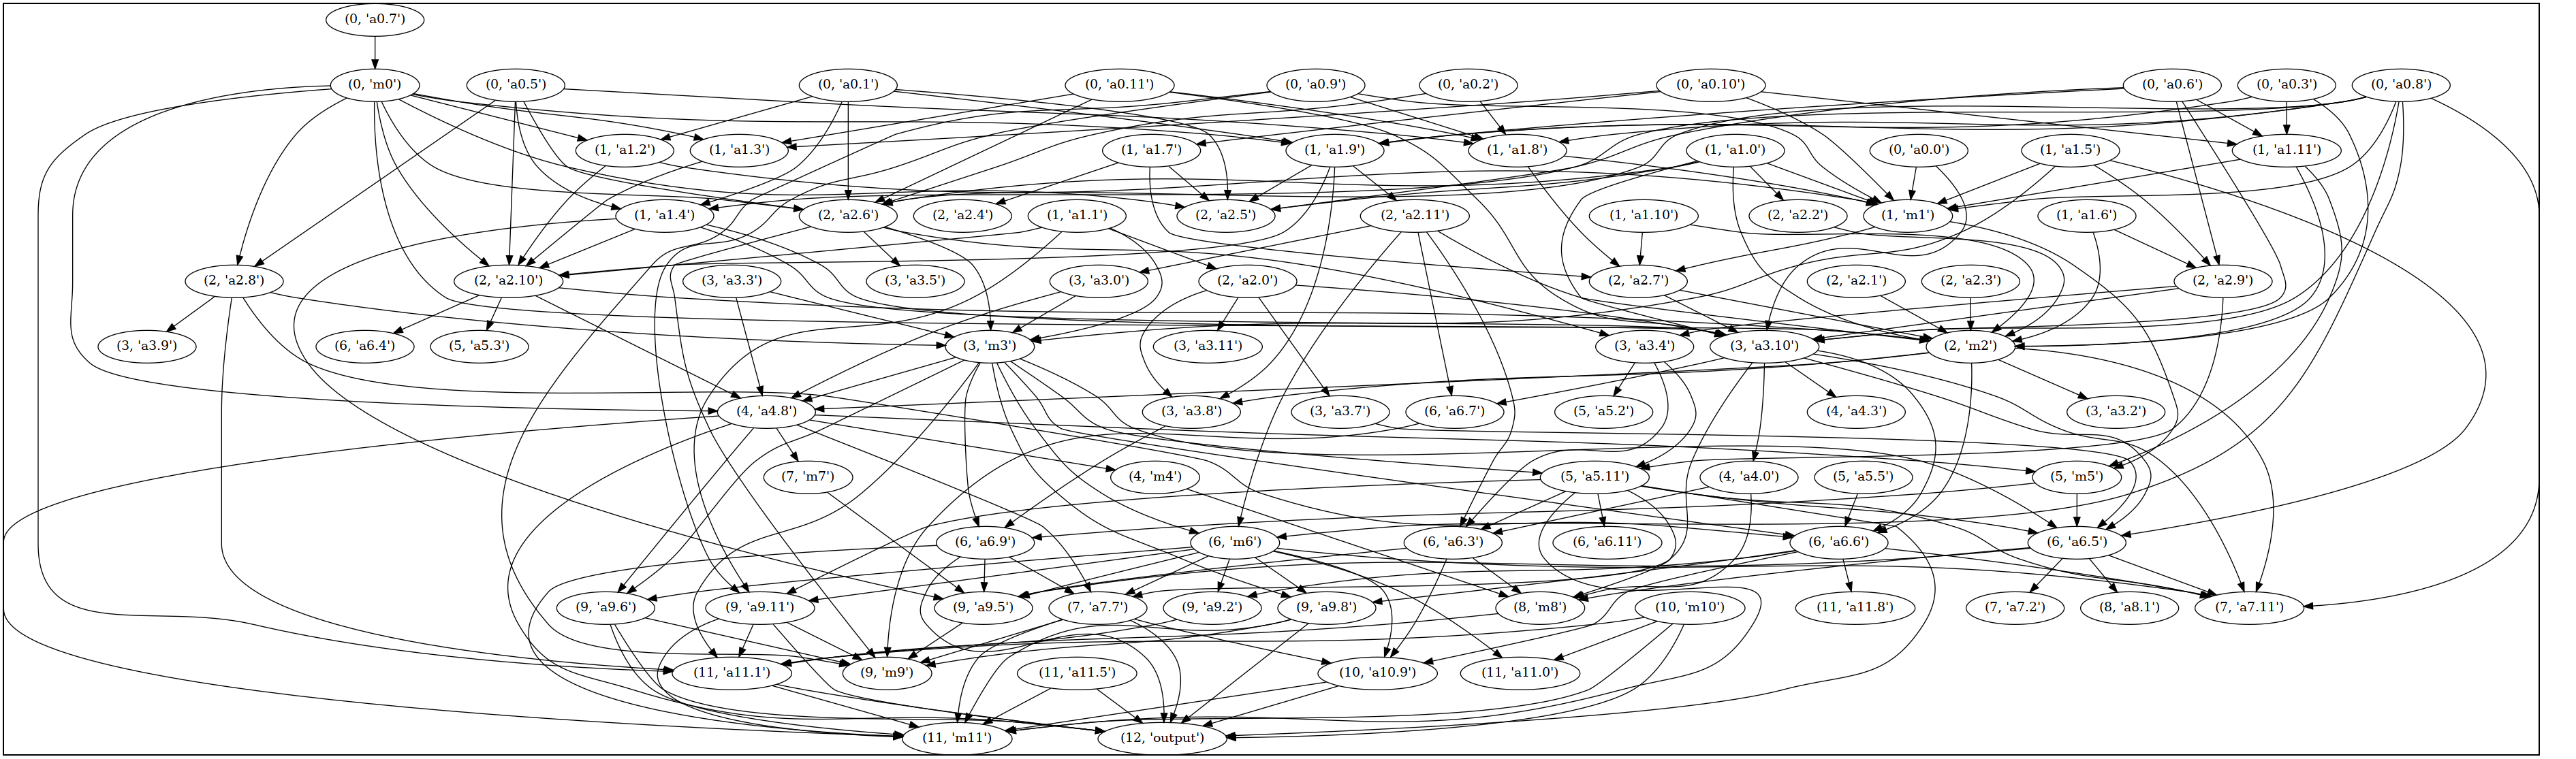

In [42]:
import pygraphviz as pgv
from IPython.display import Image

# This function assumes that `edges` is a list of tuples (src, dst) representing the actual connections
def create_hierarchical_graph(all_possible_nodes, edges):
    G = pgv.AGraph(strict=False, directed=True)

    # Add only the nodes that have edges
    nodes_with_edges = set([node for edge in edges for node in edge])
    # for layer, node in all_possible_nodes:
    #     if node in nodes_with_edges:
    #         G.add_node(node, layer=layer)
    
    # Add edges to the graph
    for edge in edges:
        G.add_edge(edge[1], edge[0])

    # Organize nodes by layers
    for layer in range(-1, 13):  # plus one to include the output layer
        with G.subgraph(name=f'cluster_{layer}') as s:
            s.graph_attr['rank'] = 'same'
            nodes_in_layer = [node for (l, node) in all_possible_nodes if l == layer]
            for node in nodes_in_layer:
                if node in nodes_with_edges:
                    s.add_node(node)
            # Optionally, for the first layer set the 'embed' node at the top
            if layer == -1:
                s.graph_attr['rank'] = 'min'

    # Use dot prog for hierarchical layout
    G.layout(prog='dot')

    # Draw and show the graph
    G.draw('graph.png')
    return Image('graph.png')

# Call the function with your nodes and edges
hierarchical_graph_image = create_hierarchical_graph(all_possible_nodes, edges)

with open("graphs/graph.png", "wb") as f:
    f.write(hierarchical_graph_image.data)

# To display the graph in Jupyter Notebook
hierarchical_graph_image


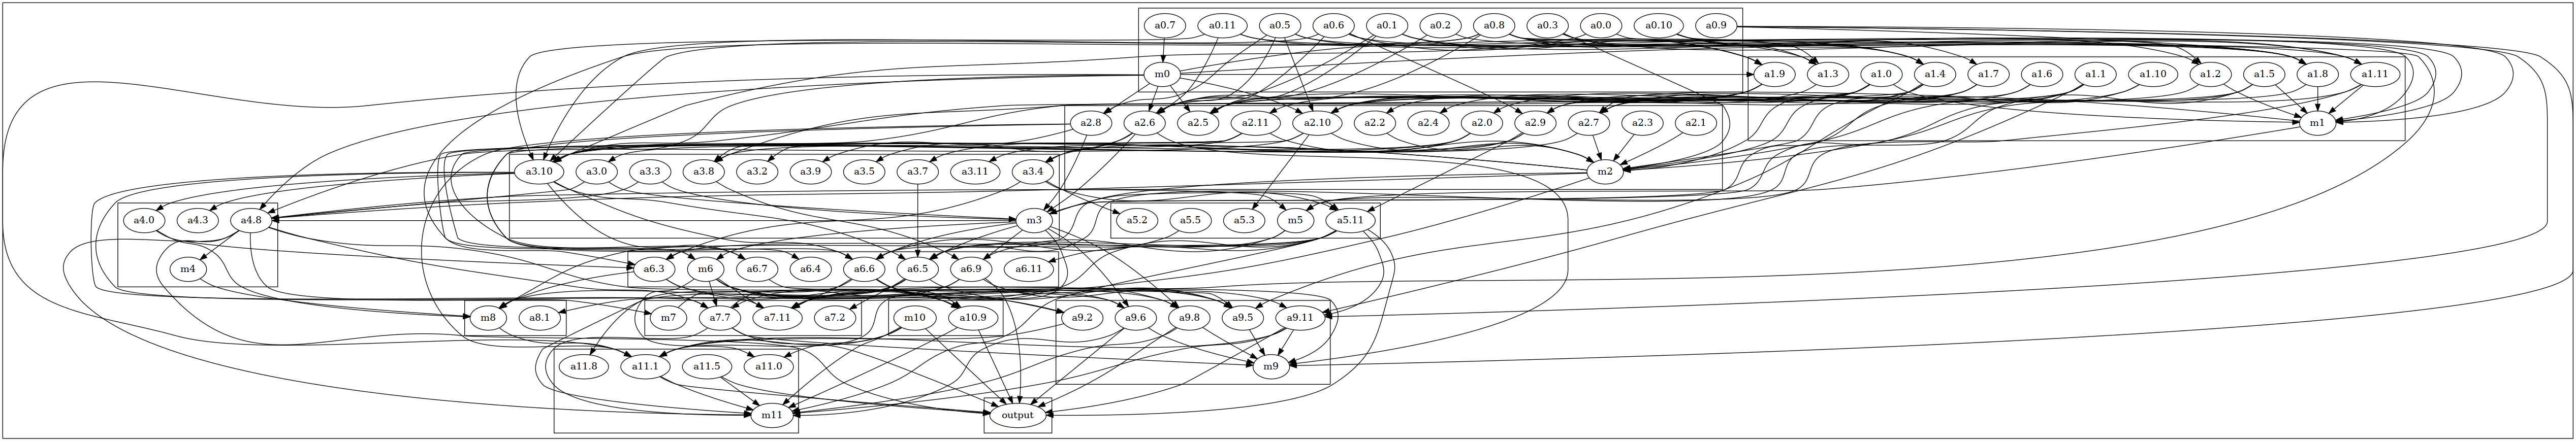

In [45]:
def create_aligned_graph(all_possible_nodes, edges):
    G = pgv.AGraph(strict=False, directed=True)

    # Find the maximum layer number for adjusting the graph
    max_layer = max(layer for layer, _ in all_possible_nodes if isinstance(layer, int))
    nodes_with_edges = set([node for edge in edges for node in edge])

    # Add nodes and edges to the graph
    for node in all_possible_nodes:
        if node in [edge[0] for edge in edges] or node in [edge[1] for edge in edges]:
            G.add_node(node[1], layer=str(max_layer - node[0]))

    for edge in edges:
        G.add_edge(edge[1][1], edge[0][1])

    # Create subgraphs to ensure nodes of the same layer have the same rank
    for layer in range(max_layer, -2, -1):
        with G.subgraph(name=f'cluster_{layer}') as s:
            s.graph_attr['rank'] = 'same'
            for node in nodes_with_edges:
                if node[0] == layer:
                    s.add_node(node[1])

    # Apply layout and render the graph
    G.layout(prog='dot')
    G.draw('aligned_graph.png')
    return Image('aligned_graph.png')

# Call the function with your nodes and edges
flipped_graph_image = create_aligned_graph(all_possible_nodes, edges)

# To display the graph in Jupyter Notebook
flipped_graph_image
